In [2]:
import io
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving Trips_by_Distance.csv to Trips_by_Distance (1).csv


In [8]:
import matplotlib.pyplot as plt

In [148]:
employee_data = pd.read_csv('employee_airline (2).csv', engine='python')
employee_data

,YEAR,MONTH,AIRLINE_ID,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,CARRIER,CARRIER_NAME,CARRIER_GROUP,CARRIER_GROUP_NEW,EMPFULL,EMPPART,EMPTOTAL,EMPFTE
0,2019,1,21161,09Q,"Swift Air, LLC d/b/a Eastern Air Lines d/b/a E...",09Q,"Swift Air, LLC d/b/a Eastern Air Lines d/b/a E...",2,2,481,36,517,499
1,2019,1,21352,0WQ,Avjet Corporation,0WQ,Avjet Corporation,1,1,154,0,154,154
2,2019,1,21492,1BQ,"Eastern Airlines f/k/a Dynamic Airways, LLC",1BQ,"Eastern Airlines f/k/a Dynamic Airways, LLC",1,1,174,3,177,176
3,2019,1,21518,1EQ,"KaiserAir, Inc.",1EQ,"KaiserAir, Inc.",1,4,39,29,68,54
4,2019,1,21652,27Q,"Jet Aviation Flight Services, Inc.",27Q,"Jet Aviation Flight Services, Inc.",1,1,765,1,766,766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,2021,3,20377,X9,Omni Air International LLC,X9,Omni Air International LLC,2,2,1123,2,1125,1124
1608,2021,3,20207,XP,Xtra Airlines� dba� Avelo Airlines,XP,XTRA Airways,1,4,140,4,144,142
1609,2021,3,20378,YV,Mesa Airlines Inc.,YV,Mesa Airlines Inc.,2,2,3048,10,3058,3053
1610,2021,3,20452,YX,Republic Airline,YX,Republic Airline,3,3,5307,243,5550,5429


In [163]:
employee = pd.DataFrame()
employee["date"] = pd.to_datetime(employee_data[['YEAR', 'MONTH']].assign(DAY=1))
employee["empfull"] = employee_data["EMPFULL"]
employee["emptotal"] = employee_data["EMPTOTAL"]
employee

,date,empfull,emptotal
0,2019-01-01,481,517
1,2019-01-01,154,154
2,2019-01-01,174,177
3,2019-01-01,39,68
4,2019-01-01,765,766
...,...,...,...
1607,2021-03-01,1123,1125
1608,2021-03-01,140,144
1609,2021-03-01,3048,3058
1610,2021-03-01,5307,5550


In [164]:
employee = employee.groupby(["date"]).sum()

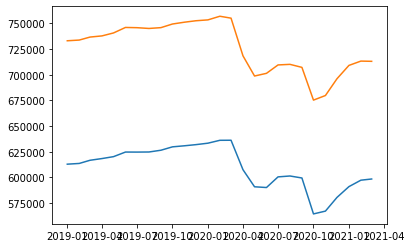

In [165]:
plt.plot(employee)

In [113]:
trips = pd.read_csv('Trips_by_Distance (1).csv')
trips.sort_values(by="Date")

,Date,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
1048574,1/1/2019,3930.0,7915.0,29312.0,2919.0,5405.0,1579.0,1240.0,246.0,69.0,42.0
1046885,1/1/2019,13887.0,42622.0,147567.0,22139.0,22850.0,9607.0,2260.0,1948.0,278.0,91.0
1046884,1/1/2019,18558.0,55469.0,209657.0,28871.0,20586.0,6184.0,3948.0,1911.0,482.0,143.0
1046883,1/1/2019,7972.0,20763.0,69166.0,7965.0,7708.0,5578.0,1761.0,793.0,155.0,53.0
1046882,1/1/2019,2427.0,7264.0,25096.0,3012.0,3339.0,3163.0,667.0,378.0,86.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
9642,9/9/2020,216972.0,520466.0,1893242.0,302463.0,206383.0,101313.0,33730.0,8796.0,6844.0,8137.0
9643,9/9/2020,326948.0,1029510.0,4620426.0,698486.0,836288.0,383083.0,120196.0,20395.0,3282.0,5404.0
9644,9/9/2020,2552804.0,6355716.0,28639274.0,4193607.0,4314763.0,1581717.0,545913.0,172080.0,40641.0,48041.0
9634,9/9/2020,2066918.0,4835231.0,23536247.0,3540557.0,3663889.0,1305714.0,370782.0,94087.0,25971.0,53704.0


In [120]:
trips = trips.groupby(["Date"]).sum()
trips = trips.rename_axis('Date').reset_index()
trips.head()

ValueError: ignored

In [121]:
trips.index = pd.to_datetime(trips['Date'])
trips = trips.resample('W').mean()
trips = trips.rename_axis('Date').reset_index()

In [124]:
trips["Number of Trips (25-500)"] = trips["Number of Trips 25-50"]+trips["Number of Trips 50-100"]+trips["Number of Trips 100-250"]+trips["Number of Trips 250-500"]+trips["Number of Trips >=500"]
trips["Number of Trips (25-500)"] = trips["Number of Trips (25-500)"].rolling(window=6).mean()
trips.dropna()

,Date,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Number of Trips (25-500)
5,2019-02-10,1.909927e+08,7.874595e+08,4.312817e+09,6.799613e+08,6.727407e+08,2.060498e+08,5.899473e+07,2.242861e+07,5.503909e+06,7.443007e+06,2.681131e+08
6,2019-02-17,1.792469e+08,7.526189e+08,3.424884e+09,5.339600e+08,5.159704e+08,1.668233e+08,5.399472e+07,2.278693e+07,5.451137e+06,4.334843e+06,2.638466e+08
7,2019-02-24,1.875472e+08,7.909463e+08,3.421891e+09,5.226365e+08,4.994053e+08,1.676298e+08,5.648646e+07,2.538018e+07,6.229196e+06,4.712737e+06,2.629564e+08
8,2019-03-03,1.884741e+08,7.900191e+08,3.410582e+09,5.183301e+08,4.977234e+08,1.646872e+08,5.389146e+07,2.387637e+07,5.865810e+06,4.543476e+06,2.626864e+08
9,2019-03-10,1.888153e+08,7.896310e+08,4.413331e+09,7.008986e+08,7.030370e+08,2.138898e+08,5.754754e+07,2.036337e+07,5.066707e+06,7.262739e+06,2.706666e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
104,2021-01-03,1.824374e+08,4.718974e+08,1.974163e+09,3.024469e+08,2.984200e+08,9.669038e+07,3.428970e+07,1.677457e+07,3.487542e+06,1.681132e+06,1.636621e+08
111,2021-02-21,1.606499e+08,4.936850e+08,2.255674e+09,3.485356e+08,3.297326e+08,1.036259e+08,3.466013e+07,1.471007e+07,3.090019e+06,2.125915e+06,1.505269e+08
112,2021-02-28,1.484471e+08,5.058878e+08,2.437849e+09,3.745375e+08,3.573826e+08,1.138084e+08,3.759563e+07,1.480842e+07,2.903654e+06,1.841919e+06,1.541659e+08
113,2021-03-07,1.703946e+08,4.839402e+08,2.086616e+09,3.229400e+08,3.079966e+08,9.639207e+07,3.229277e+07,1.482827e+07,3.278426e+06,1.643207e+06,1.541894e+08


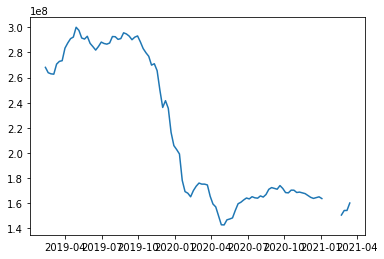

In [125]:
plt.plot(trips["Date"], trips["Number of Trips (25-500)"])

In [126]:
trips["Population Staying at Home"] = trips.rolling(window=7).mean()
trips["Population Not Staying at Home"] = trips.rolling(window=7).mean()

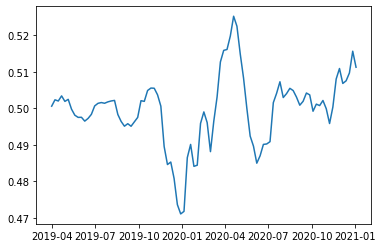

In [127]:
plt.plot(trips["Date"], trips["Population Staying at Home"]/(trips["Population Not Staying at Home"]+trips["Population Staying at Home"]))

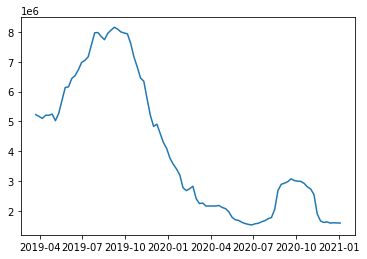

In [128]:
trips["Number of Trips >=500"] = trips["Number of Trips >=500"].rolling(window=12).mean()
trips.dropna()
plt.plot(trips["Date"], trips["Number of Trips >=500"])

In [129]:
from traffic.data import airports
import altair as alt

airports_subset = [
    # Europe
    ["LFPG", "EGLL", "EHAM", "EDDF", "LEMD", "LIRF", "LSZH", "UUEE"],
    # Eastern Asia
    ["VHHH", "RJBB", "RJTT", "RKSI", "RCTP", "RPLL"],
    # Asia (other)
    ["YSSY", "YMML", "OMDB", "VABB", "VIDP", "WSSS"],
    # Americas
    ["CYYZ", "KSFO", "KLAX", "KATL", "KJFK", "SBGR"],
]

data = pd.concat(
    (
        flightlist.query(f'origin == "{airport}"')
        # count the number of departing aircraft per day
        .groupby("day")
        .agg(dict(callsign="count"))
        # label the current chunk with the name of the airport
        .rename(columns=dict(callsign=airport))
        # iterate on all airports in the list hereabove
        for airport in sum(airports_subset, [])
    ),
    axis=1,
)

chart = alt.Chart(
    data.reset_index()
    # prepare data for altair
    .melt("day", var_name="airport", value_name="count")
    # include the name of the city associated with the airport code
    .merge(
        airports.data[["icao", "municipality"]],
        left_on="airport",
        right_on="icao",
        how="left",
    )[["day", "airport", "count", "municipality"]]
    # rename this feature 'city'
    .rename(columns=dict(municipality="city"))
)


def full_chart(source, subset, subset_name):

    # We have many airports, only pick a subset
    chart = source.transform_filter(
        alt.FieldOneOfPredicate(field="airport", oneOf=subset)
    )

    # When we come close to a line, highlight it
    highlight = alt.selection(
        type="single", nearest=True, on="mouseover", fields=["airport"]
    )

    # The scatter plot
    points = (
        chart.mark_point()
        .encode(
            x="day",
            y=alt.Y("count", title="# of departing flights"),
            color=alt.Color("airport", legend=alt.Legend(title=subset_name)),
            # add some legend next to  point
            tooltip=["day", "airport", "city", "count"],
            # not too noisy please
            opacity=alt.value(0.5),
        )
        .add_selection(highlight)
    )

    # The trend plot
    lines = (
        chart.mark_line()
        .encode(
            x="day",
            y="count",
            color="airport",
            size=alt.condition(~highlight, alt.value(1), alt.value(3)),
        )
        # the cloud is a bit messy, draw a trend through it
        .transform_loess("day", "count", groupby=["airport"], bandwidth=0.2)
    )

    return lines + points


# Concatenate several plots
result = alt.vconcat(
    *[
        full_chart(chart, airport_, subset_name).properties(width=600, height=150)
        for subset_name, airport_ in zip(
            [
                "European airports",
                "East-Asian airports",
                "Asian/Australian airports",
                "American airports",
            ],
            airports_subset,
        )
    ]
).resolve_scale(color="independent")

result

ModuleNotFoundError: ignored

In [142]:
jets = pd.read_csv(io.BytesIO(uploaded['HistoricalData_1621077071948.csv']))
jets.head()

KeyError: ignored

In [ ]:
plt.plot(jets["Date"], jets["Close/Last"])

In [ ]:
import time
import intrinio_sdk
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from intrinio_sdk.rest import ApiException
from pprint import pprint

   
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OjFmYWZmNmZkNDQxZDM2OTRlNWU3ZDg1NzhmZDc0NjZk'

company_api = intrinio_sdk.CompanyApi()
PAGE_SIZE = 10000 # number of results to return 
next_page = '' # gets the next page of data from a previous API call (optional)

In [ ]:
company_api

In [85]:
def inPassage(passage, list): 
    for word in list:
        if word in passage:
            return True 
    return False

In [86]:
def createColumn(df, columnName, list):
    df[columnName] = df['summary'].apply(inPassage, args=(list,))

In [87]:
# create dictionaries of words relating to each pillar of ESG. code can be improved by adding to these
eWords = {'environment', 'climate', 'sustainable', 'sustainability', 'green', 'planet'}
sWords = {'social','community', 'responsibility', 'philanthropy', 'charity'}
gWords = {'governance', 'board', 'administration', 'organization', 'conduct'}

In [88]:
def getSentimentScore(passage):
    try:
        score = sia.polarity_scores(str(passage))['compound']
    except TypeError:
        score = 0
    return score

In [89]:
def getESGscore(ticker):
    try:
        api_response = company_api.get_company_news(ticker, page_size=PAGE_SIZE, next_page=next_page)
    except ApiException as e:
        print("Exception when calling CompanyApi->get_company_news: %s\r\n" % e)
    
    df = pd.DataFrame(api_response.news_dict)
    del df['id']
    
    createColumn(df, 'eContent', eWords)
    createColumn(df, 'sContent', sWords)
    createColumn(df, 'gContent', gWords)
    
    df['sentiment'] = df.summary.apply(getSentimentScore)
    
    # define the scores as the sum of the sentiments of the articles containing content relating to env, soc or gov divided by total number of articles fetched
    eScore = df[df['eContent'] == True].sum()['sentiment'] / PAGE_SIZE
    sScore = df[df['sContent'] == True].sum()['sentiment'] / PAGE_SIZE
    gScore = df[df['gContent'] == True].sum()['sentiment'] / PAGE_SIZE
    
    return [eScore, sScore, gScore]

In [90]:
try:
    api_response = company_api.get_company_news('BA', page_size=PAGE_SIZE, next_page=next_page)
except ApiException as e:
    print("Exception when calling CompanyApi->get_company_news: %s\r\n" % e)
    
df = pd.DataFrame(api_response.news_dict)
del df['id']

df['sentiment'] = df.summary.apply(getSentimentScore)

createColumn(df, 'eContent', eWords)
createColumn(df, 'sContent', sWords)
createColumn(df, 'gContent', gWords)

# define the scores as the sum of the sentiments of the articles containing content relating to env, soc or gov divided by total number of articles fetched
eScore = df[df['eContent'] == True].sum()['sentiment'] / PAGE_SIZE
sScore = df[df['sContent'] == True].sum()['sentiment'] / PAGE_SIZE
gScore = df[df['gContent'] == True].sum()['sentiment'] / PAGE_SIZE

In [91]:
df

,title,publication_date,url,summary,sentiment,eContent,sContent,gContent
0,EU trade chief calls on U.S. to drop tariffs i...,2020-10-11 12:30:28+00:00,https://finance.yahoo.com/news/eu-trade-chief-...,Repairing the transatlantic relationship would...,-0.0516,False,False,False
1,Dow Jones Stocks To Buy And Watch In October 2...,2020-10-10 15:05:33+00:00,https://finance.yahoo.com/m/65b53896-faf4-3a06...,"Among the Dow Jones stocks, Apple and Microsof...",0.2023,False,False,False
2,Boeing Slashes 10-Year Demand Forecast (but Ma...,2020-10-10 14:06:00+00:00,https://finance.yahoo.com/m/8ae8676f-4131-363b...,"Earlier this week, Boeing (NYSE: BA) released ...",0.5859,False,False,False
3,"Airbus ramps up deliveries in September, seen ...",2020-10-09 18:05:23+00:00,https://ca.finance.yahoo.com/news/airbus-ramps...,Airbus <AIR.PA> reached the highest number of ...,-0.8945,False,False,False
4,Is American Airlines Stock A Buy? Here's What ...,2020-10-09 16:32:50+00:00,https://finance.yahoo.com/m/d3a2667e-a8d6-3986...,American Airlines stock has suffered shocks fr...,-0.7906,False,False,False
...,...,...,...,...,...,...,...,...
9995,Post-Crash Scrutiny Makes Boeing Stock One To ...,2019-05-23 14:09:10+00:00,http://articlefeeds.nasdaq.com/~r/nasdaq/symbo...,InvestorPlace Stock Market News Stock Advice a...,-0.2500,False,False,False
9996,"Ralph Nader, whose grandniece died in latest 7...",2019-05-23 14:06:04+00:00,https://finance.yahoo.com/m/48ffefce-c662-3dc5...,Consumer advocate Ralph Nader is calling for a...,-0.9118,False,False,False
9997,Boeing Wins Deal to Offer Training Services fo...,2019-05-23 13:54:01+00:00,https://finance.yahoo.com/news/boeing-wins-dea...,"Boeing (BA) will provide contractor-furnished,...",0.0000,False,False,False
9998,Boeing Shares Drift Lower as FAA Says 'No Time...,2019-05-23 13:33:00+00:00,https://finance.yahoo.com/m/e98b79f8-c726-33ae...,shares extended declines Thursday following co...,0.2263,False,False,False


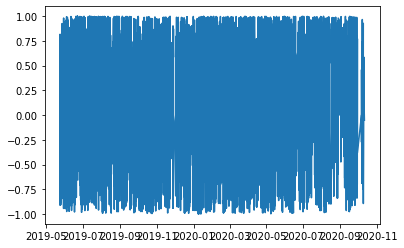

In [92]:
import matplotlib.pyplot as plt
plt.plot(df['publication_date'], df['sentiment'])

In [93]:
fin_sent = pd.DataFrame()
fin_sent['publication_date'] = df['publication_date']
fin_sent['sentiment'] = df['sentiment']
fin_sent

,publication_date,sentiment
0,2020-10-11 12:30:28+00:00,-0.0516
1,2020-10-10 15:05:33+00:00,0.2023
2,2020-10-10 14:06:00+00:00,0.5859
3,2020-10-09 18:05:23+00:00,-0.8945
4,2020-10-09 16:32:50+00:00,-0.7906
...,...,...
9995,2019-05-23 14:09:10+00:00,-0.2500
9996,2019-05-23 14:06:04+00:00,-0.9118
9997,2019-05-23 13:54:01+00:00,0.0000
9998,2019-05-23 13:33:00+00:00,0.2263


In [101]:
for i in range(0,df.shape[0]-2):
    fin_sent.loc[fin_sent.index[i+2],'SMA_15'] = np.round(((fin_sent.iloc[i,1]+ fin_sent.iloc[i+1,1] +fin_sent.iloc[i+2,1]+fin_sent.iloc[i+2,1]+fin_sent.iloc[i+2,1])/3),1)
fin_sent

,publication_date,sentiment,SMA_3,SMA_15
0,2020-10-11 12:30:28+00:00,-0.0516,NaN,NaN
1,2020-10-10 15:05:33+00:00,0.2023,NaN,NaN
2,2020-10-10 14:06:00+00:00,0.5859,0.2,0.6
3,2020-10-09 18:05:23+00:00,-0.8945,-0.0,-0.6
4,2020-10-09 16:32:50+00:00,-0.7906,-0.4,-0.9
...,...,...,...,...
9995,2019-05-23 14:09:10+00:00,-0.2500,-0.3,-0.5
9996,2019-05-23 14:06:04+00:00,-0.9118,-0.5,-1.1
9997,2019-05-23 13:54:01+00:00,0.0000,-0.4,-0.4
9998,2019-05-23 13:33:00+00:00,0.2263,-0.2,-0.1


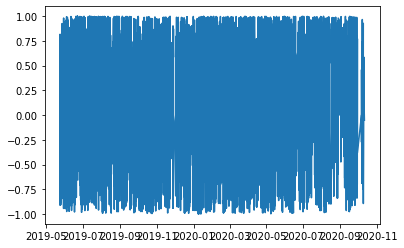

In [97]:
plt.plot(df['publication_date'], df['sentiment'])

In [82]:
scores = getESGscore(input('Please enter a ticker: '))
print("Environment: {0} Social: {1} Governance: {2}".format(scores[0], scores[1], scores[2]))

KeyboardInterrupt: ignored

[[0.010818000000000001, -0.0038179999999999998, 4.900000000000071e-05]]


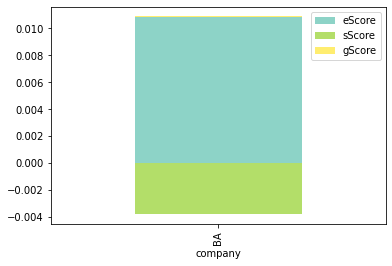

In [49]:
import numpy as np
import matplotlib.pyplot as plt

companies = ['BA']
scoreList = []

for company in companies:
    scoreList.append(getESGscore(company))
    
print(scoreList)

esgData = pd.DataFrame(scoreList, columns=['eScore', 'sScore','gScore'])
esgData.insert(0, 'company', companies)
esgData

esgData.plot(kind='bar', x='company', stacked=True, cmap='Set3')